# Quantizing a model with FuriosaAI SDK for image classification tasks


This notebook shows how to apply quantization using FuriosaAI SDK, for image classification task. This is made possible thanks to 🤗 Optimum, an extension of 🤗 Transformers, providing a set of performance optimization tools enabling maximum efficiency to train and run models on targeted hardwares.

The notebook showcases quantization using **Optimum Furiosa** with end-to-end integration with **Hugging Face libraries, 🤗 Transformers, 🤗 Datasets, 🤗 Evaluate and 🤗 Optimum**.

If you're opening this Notebook on colab, you will probably need to install below packages. Uncomment the following cell and run it.

In [1]:
# !pip install -q "git+https://github.com/huggingface/optimum-furiosa.git" optimum onnx transformers evaluate datasets

We will apply post-training static quantization on a Resnet-50 model fine-tuned on the beans dataset

In [2]:
task = "image-classification"
model_checkpoint = "eugenecamus/resnet-50-base-beans-demo"

## Dataset

Beans is a leaf dataset with images of diseased and health leaves.

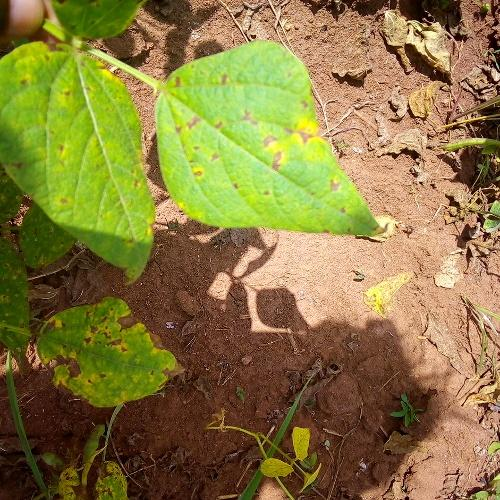

In [3]:
import requests
from PIL import Image

url = "https://datasets-server.huggingface.co/assets/beans/--/default/train/0/image/image.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

### Loading the dataset and metrics
We will use the 🤗 Datasets library to download the dataset and 🤗 Evaluate library to get the metric we need to use for evaluation. This can be easily done with the functions load_dataset and load.

In [4]:
from datasets import load_dataset
from evaluate import load

eval_dataset = load_dataset("beans", split="validation")
metric = load("accuracy")

Found cached dataset beans (/home/ubuntu/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


## Applying quantization on the model

Post training quantization introduces an additional calibration step where data is fed through the network in order to compute the activations quantization parameters.

First, let's create the output directory where the resulting quantized model will be saved.

In [5]:
import os

model_name = model_checkpoint.split("/")[-1]
output_dir = f"{model_name}-quantization"
os.makedirs(output_dir, exist_ok=True)

### Export the model to ONNX

In [6]:
from pathlib import Path
from functools import partial

from transformers import AutoFeatureExtractor
from optimum.furiosa.utils import export_model_to_onnx

In [7]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

batch_size = 1
image_size = feature_extractor.size["shortest_edge"]
num_labels = 3
onnx_model_name = "model.onnx"
onnx_model_path = Path(output_dir) / onnx_model_name

export_model_to_onnx(
    model_checkpoint,
    save_dir=output_dir,
    input_shape_dict={"pixel_values": [batch_size, 3, image_size, image_size]},
    output_shape_dict={"logits": [batch_size, num_labels]},
    file_name=onnx_model_name,
)

/home/ubuntu/miniconda3/envs/furiosa-3.8-hf/lib/python3.8/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(
Framework not specified. Using pt to export to ONNX.
Using framework PyTorch: 2.0.0+cu117
/home/ubuntu/miniconda3/envs/furiosa-3.8-hf/lib/python3.8/site-packages/transformers/models/resnet/modeling_resnet.py:94: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:


============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [8]:
from optimum.furiosa import FuriosaAIQuantizer, FuriosaAIModelForImageClassification

# Create a quantizer from a FuriosaModel
quantizer = FuriosaAIQuantizer.from_pretrained(output_dir, file_name=onnx_model_name)

libfuriosa_hal.so --- v0.11.0, built @ 43c901f
libfuriosa_hal.so --- v2.0, built @ 9928508
INFO:furiosa.common.native:loaded native library libnux.so (0.9.0 e626c458c)


In [9]:
def preprocess_fn(ex, feature_extractor):
    return feature_extractor(ex["image"])

In [10]:
from optimum.furiosa.configuration import QuantizationConfig, AutoCalibrationConfig

# Create the quantization configuration containing all the quantization parameters
qconfig = QuantizationConfig()

# Create the calibration dataset used for the calibration step
calibration_dataset = quantizer.get_calibration_dataset(
    "beans",
    preprocess_function=partial(preprocess_fn, feature_extractor=feature_extractor),
    num_samples=100,
    dataset_split="train",
)

calibration_config = AutoCalibrationConfig.mse_asym(calibration_dataset)

# Perform the calibration step: computes the activations quantization ranges
ranges = quantizer.fit(
    dataset=calibration_dataset,
    calibration_config=calibration_config,
)

Using static quantization schema (dataset: beans, method: 6)
Creating calibrator: 6(CalibrationConfig(dataset_name='beans', dataset_config_name='default', dataset_split='train', dataset_num_samples=100, method=<CalibrationMethod.MSE_ASYM: 6>, percentage=None))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]
Computing calibration ranges


In [11]:
quantizer.quantize(
    save_dir=output_dir,
    calibration_tensors_range=ranges,
    quantization_config=qconfig,
)

Quantizing model...
Saving quantized model at: resnet-50-base-beans-demo-quantization
Configuration saved in resnet-50-base-beans-demo-quantization/furiosa_config.json


PosixPath('resnet-50-base-beans-demo-quantization')

## Evaluation
To evaluate our resulting quantized model we need to define how to compute the metrics from the predictions.

In [12]:
import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)

    result = metric.compute(predictions=preds, references=p.label_ids)
    return result

In [13]:
eval_dataset = eval_dataset.map(partial(preprocess_fn, feature_extractor=feature_extractor), batched=True)

Finally, to estimate the drop in performance resulting from quantization, we are going to perform an evaluation step for both models (before and after quantization). In order to perform the latter, we will need to instantiate an FuriosaAIModelForImageClassification and thus need:

* The path of the model to evaluate.
* The dataset to use for the evaluation step.
* The function that will be used to compute the evaluation metrics compute_metrics that was defined previously.

### Evaluate FP32 model

In [12]:
furiosa_model = FuriosaAIModelForImageClassification.from_pretrained(
    Path(output_dir),
    file_name="model.onnx",
    compute_metrics=compute_metrics,
    label_names=["labels"],
)
model_output = furiosa_model.evaluation_loop(eval_dataset)

Compiling the model and creating the session ...
Saving the compilation log into /home/ubuntu/.local/state/furiosa/logs/compile-20230524084043-388y6d.log
Using furiosa-compiler 0.9.0 (rev: e626c458c built at 2023-04-19T13:49:26Z)


2023-05-24T08:40:43.771892Z  INFO nux::npu: Npu (npu0pe0-1) is being initialized
2023-05-24T08:40:43.774913Z  INFO nux: NuxInner create with pes: [PeId(0)]


***** Running evaluation *****
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [2:32:00<00:00, 68.58s/it]


In [13]:
model_output.metrics

{'accuracy': 0.9323308270676691}

### Evaluate quantized model

In [14]:
furiosa_model_quantized = FuriosaAIModelForImageClassification(
    Path(output_dir) / "model_quantized.dfg",
    compute_metrics=compute_metrics,
    label_names=["labels"],
)
quant_model_output = furiosa_model_quantized.evaluation_loop(eval_dataset)

Compiling the model and creating the session ...
Saving the compilation log into /home/ubuntu/.local/state/furiosa/logs/compile-20230525075929-k7637t.log
Using furiosa-compiler 0.9.0 (rev: e626c458c built at 2023-04-19T13:49:26Z)


2023-05-25T07:59:29.586226Z  INFO nux::npu: Npu (npu0pe0-1) is being initialized
2023-05-25T07:59:29.589252Z  INFO nux: NuxInner create with pes: [PeId(0)]


***** Running evaluation *****
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:12<00:00, 10.97it/s]


In [15]:
quant_model_output.metrics

{'accuracy': 0.9097744360902256}